In [1]:
import os
import imageio

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

2023-11-22 04:33:57.597003: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-22 04:33:57.664094: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 04:33:57.664143: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 04:33:57.664189: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-22 04:33:57.674177: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-22 04:33:57.675078: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# Build a Generator

In [2]:
class GifIterator:
    def __init__(self, filenames, answers, batch_size=64, rescale=None, shuffle=True):
        """
        Yields batches (X, y)
        """
        self.filenames = np.array(filenames)
        self.answers = np.array(answers)
        self.batch_size = batch_size
        self.rescale = rescale
        if len(self.filenames) != len(self.answers):
            raise ValueError("filenames and answers arrays have different lengths.")
        self.length = (len(self.answers) - 1)//self.batch_size + 1
        self.shuffle = shuffle
        self.batch_index = 0
        self.indexes = np.arange(len(self.answers))
        if shuffle:
            np.random.shuffle(self.indexes)
    
    
    def reshuffle(self):
        self.indexes = np.arange(len(self.answers))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    
    def __len__(self):
        return self.length
    
        
    def on_epoch_end(self):
        self.batch_index = 0
        self.reshuffle()
        
        
    def __getitem__(self, idx):
        if idx >= len(self):
            raise ValueError(
                "Asked to retrieve element {idx}, "
                "but the Sequence "
                "has length {length}".format(idx=idx, length=len(self))
            )
        
        if idx == len(self) - 1:
            indexes_i = self.indexes[idx*self.batch_size:]
        else:
            indexes_i = self.indexes[idx*self.batch_size:(idx + 1)*self.batch_size]
        filenames_i = self.filenames[indexes_i]
        answers_i = self.answers[indexes_i]
        X = np.array([np.array(imageio.mimread(filename)) for filename in filenames_i])
        if self.rescale is not None:
            X = X*self.rescale
        y = answers_i
        return X, y
    
    
    def __iter__(self):
        return self
    
    
    def __next__(self):
        self.batch_index += 1
        if self.batch_index > len(self):
            self.on_epoch_end()
            self.batch_index = 0  # Reset batch index for the new epoch
            raise StopIteration
        return self[self.batch_index - 1]
    

In [3]:
class GifBinaryGenerator:
    def __init__(self, batch_size=64, rescale=None):
        """
        """
        self.batch_size = batch_size
        self.rescale = rescale
        self.droped = []
    
    def prepare_by_paths(self, path_class_0=None, path_class_1=None, check_length=True, gif_length=4):
        """
        
        Parameters:
        -----------
        -----------
        path_class_0 : str
            The way to class, label 0
            
        path_class_1 : str
            The way to class, label 1
            
        check_length : bool
            Drop files if their length not correct
            
        gif_length : int
            Ignoring gifs with another lengths
        """
        if check_length:
            files0 = []
            print('Checking GIF-files for correct length:')
            pbar = tqdm(total=len(os.listdir(path_class_0)) + len(os.listdir(path_class_1)))
            for file in [os.path.join(path_class_0, filename) for filename in os.listdir(path_class_0)]:
                X = np.array(imageio.mimread(file))
                if len(X) == gif_length:
                    files0.append(file)
                else:
                    self.droped.append(file)
                pbar.update()
            files1 = []
            for file in [os.path.join(path_class_1, filename) for filename in os.listdir(path_class_1)]:
                X = np.array(imageio.mimread(file))
                if len(X) == gif_length:
                    files1.append(file)
                else:
                    self.droped.append(file)
                pbar.update()
            pbar.close()
        else:
            files0 = [os.path.join(path_class_0, filename) for filename in os.listdir(path_class_0)]
            files1 = [os.path.join(path_class_1, filename) for filename in os.listdir(path_class_1)]
        self.files0 = np.array(files0)
        self.files1 = np.array(files1)
    
    
    def __len__(self):
        return (len(self.files0) + len(self.files1) - 1)//self.batch_size + 1
    
    
    def flow(self, path_class_0=None, path_class_1=None, shuffle=True, check_length=True, gif_length=4):
        """
        Yields tuples (X, y) of np.arrays shapes 
        (self.batch_size, gif_length, width, height, 3) and (self.batch_size)
        
        Parameters:
        -----------
        path_class_0 : str
            The way to class, label 0
            
        path_class_1 : str
            The way to class, label 1
            
        check_length : bool
            Drop files if their length not correct
            
        gif_length : int
            Ignoring gifs with another lengths
            
        """
        if (path_class_0 is not None) and (path_class_1 is not None):
            self.prepare_by_paths(path_class_0, path_class_1, check_length, gif_length)
        
        files = np.concatenate([self.files0, self.files1])
        answers = np.concatenate([np.zeros(len(self.files0)), np.ones(len(self.files1))])
        
        # Workaround: infinite loop
        while True:
            for x, y in GifIterator(files, answers, batch_size=self.batch_size, rescale=self.rescale, shuffle=shuffle):
                yield x, y

In [4]:
path_class_testing_0 = 'data/validation/noncuts'
path_class_testing_1 = 'data/validation/cuts'

gen_validation = GifBinaryGenerator(batch_size=16, rescale=1/255)
gen_validation.prepare_by_paths(path_class_testing_0, path_class_testing_1)

print(f'len(gen_validation) = {len(gen_validation)}')

print(f'\nThere are {len(gen_validation.droped)} validation files droping:\n- ' + '\n- '.join(np.sort(gen_validation.droped)))

Checking GIF-files for correct length:


  0%|          | 0/916 [00:00<?, ?it/s]

len(gen_validation) = 57

There are 7 validation files droping:
- data/validation/cuts/1-140.gif
- data/validation/cuts/1-141.gif
- data/validation/noncuts/0-2161.gif
- data/validation/noncuts/0-2166.gif
- data/validation/noncuts/1-1769.gif
- data/validation/noncuts/1-2015.gif
- data/validation/noncuts/1-2017.gif


In [5]:
path_class_training_0 = 'data/training/noncuts'
path_class_training_1 = 'data/training/cuts'

gen_training = GifBinaryGenerator(batch_size=32, rescale=1/255)
gen_training.prepare_by_paths(path_class_training_0, path_class_training_1)

print(f'len(gen_training) = {len(gen_training)}')

print(f'\nThere are {len(gen_training.droped)} validation files droping:\n- ' + '\n- '.join(np.sort(gen_training.droped)))

Checking GIF-files for correct length:


  0%|          | 0/4503 [00:00<?, ?it/s]

len(gen_training) = 140

There are 38 validation files droping:
- data/training/cuts/0-150.gif
- data/training/cuts/0-35.gif
- data/training/cuts/1-139.gif
- data/training/cuts/1-142.gif
- data/training/cuts/1-20.gif
- data/training/cuts/1-219.gif
- data/training/cuts/1-233.gif
- data/training/cuts/1-234.gif
- data/training/cuts/a-151.gif
- data/training/cuts/a-20.gif
- data/training/cuts/a-217.gif
- data/training/cuts/a-278.gif
- data/training/cuts/a-521.gif
- data/training/cuts/a-537.gif
- data/training/cuts/a-676.gif
- data/training/cuts/a-691.gif
- data/training/noncuts/0-2159.gif
- data/training/noncuts/0-2160.gif
- data/training/noncuts/0-2162.gif
- data/training/noncuts/0-2163.gif
- data/training/noncuts/0-2164.gif
- data/training/noncuts/0-2165.gif
- data/training/noncuts/1-1028.gif
- data/training/noncuts/1-1029.gif
- data/training/noncuts/1-2003.gif
- data/training/noncuts/1-2004.gif
- data/training/noncuts/1-2005.gif
- data/training/noncuts/1-2006.gif
- data/training/noncuts

GIF format sometimes contains not every frame. 

This is another reason to build generator from DataFrame and video, described in `Data Extraction and Augmentation.ipynb`

# Build a model

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(16, 3, activation='relu', input_shape=(4, 160, 90, 3)), 
    tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)), 
    tf.keras.layers.Conv3D(32, 2, activation='relu'), 
    tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)), 
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 2, 158, 88, 16)    1312      
                                                                 
 max_pooling3d (MaxPooling3  (None, 2, 79, 44, 16)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 1, 78, 43, 32)     4128      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 1, 39, 21, 32)     0         
 g3D)                                                            
                                                                 
 flatten (Flatten)           (None, 26208)             0         
                                                                 
 dense (Dense)               (None, 256)               6

In [8]:
history = model.fit(gen_training.flow(),
                    steps_per_epoch=len(gen_training), 
                    epochs=10,
                    verbose=1,
                    validation_data=gen_validation.flow(), 
                    validation_steps=len(gen_validation))

Epoch 1/10
140/140 [==============================] - 141s 1s/step - loss: 0.1819 - accuracy: 0.9427 - val_loss: 0.0875 - val_accuracy: 0.9758
Epoch 2/10
140/140 [==============================] - 139s 996ms/step - loss: 0.0716 - accuracy: 0.9825 - val_loss: 0.0956 - val_accuracy: 0.9791
Epoch 3/10
140/140 [==============================] - 139s 991ms/step - loss: 0.0513 - accuracy: 0.9850 - val_loss: 0.0828 - val_accuracy: 0.9714
Epoch 4/10
140/140 [==============================] - 138s 988ms/step - loss: 0.0439 - accuracy: 0.9868 - val_loss: 0.1024 - val_accuracy: 0.9802
Epoch 5/10
140/140 [==============================] - 139s 992ms/step - loss: 0.0330 - accuracy: 0.9890 - val_loss: 0.0844 - val_accuracy: 0.9846
Epoch 6/10
140/140 [==============================] - 140s 998ms/step - loss: 0.0228 - accuracy: 0.9924 - val_loss: 0.1004 - val_accuracy: 0.9868
Epoch 7/10
140/140 [==============================] - 140s 1s/step - loss: 0.0241 - accuracy: 0.9942 - val_loss: 0.0839 - val_a

__Without infinite loop__ in `GifBinaryGenerator.flow` Generator returns Iterator, like ImageDataGenerator. But that dies after 1st epoch. How to fix that by another way?

Maybe better change `learning_rate` parameter from `1e-3` to `1e-4`

In [9]:
assert len(history.history['val_loss']) == len(history.epoch)

# Saving results

In [10]:
import pickle

from datetime import datetime

In [11]:
now = datetime.now()
now = str(now)[:16]

print(f'Current date and timie is {now}')
now = now.replace(' ', '-').replace(':', '-')

Current date and timie is 2023-11-22 04:57


In [19]:
path_model = 'models'
path_history = 'histories'
if not os.path.isdir(path_model):
    os.mkdir(path_model)
if not os.path.isdir(path_history):
    os.mkdir(path_history)

In [20]:
path_model = os.path.join(path_model, f'{now}.h5')
path_history = os.path.join(path_history, f'{now}.pkl')

In [21]:
with open(path_history, 'wb') as file:
    pickle.dump(path_history, file)

In [25]:
model.save_weights(path_model)

# Learning History

/tmp/ipykernel_47622/1487198505.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


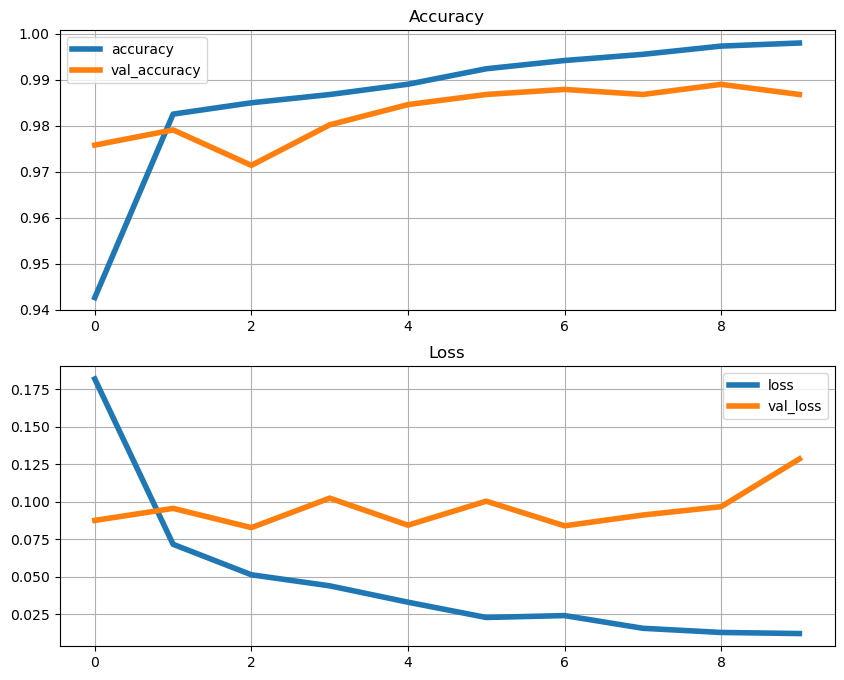

In [16]:
fig, axs = plt.subplots(2, 1)
fig.set_figwidth(10)
fig.set_figheight(8)

axs[0].set_title('Accuracy')
axs[0].plot(history.epoch, history.history['accuracy'], linewidth=4, label='accuracy')
axs[0].plot(history.epoch, history.history['val_accuracy'], linewidth=4, label='val_accuracy')
axs[0].legend()
axs[0].grid(True)

axs[1].set_title('Loss')
axs[1].plot(history.epoch, history.history['loss'], linewidth=4, label='loss')
axs[1].plot(history.epoch, history.history['val_loss'], linewidth=4, label='val_loss')
axs[1].legend()
axs[1].grid(True)

fig.show()

We can see overfitting. Maybe some Dropout layer is needed.